In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F


## Prepare data

In [2]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz
n_in_features = len(variables)-1

In [3]:
model_number = 11

train_times = pd.read_csv(Directory+f'/test_train_times/times_train_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(Directory+f'/test_train_times/times_test_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
print(train_times)
print(test_times)

[49  5 33 54 26  8 17 46 20 60 57 13 31  7 11  3 62  9 56  1 44 32 52 35
 22 58 24 47 55 42 23  2 14 27 43 10 21 34 59 45 51  4 41 29 25 18 53 19
 28]
[12 36 37 50 40 16 48 38  6 39 15 61 30]


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)
ins = [input_train, input_test]
outs = [output_train, output_test]

for j in range(len(ins)):
    input = ins[j]
    input = input.reshape(-1,len(variables)-1,nz)
    for i in range(len(variables)-1):
        input[:,i] -= torch.mean(input[:,i])
        input[:,i] /= torch.std(input[:,i])
    ins[j] = input

for i in range(len(outs)):
    output = outs[i]
    output -= torch.mean(output)
    output /= torch.std(output)
    outs[i] = output

## Def model

In [54]:
class CNN(nn.Module):
    def __init__(self, input_features, output_features, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=128, hidden_size2=256, hidden_size3=256):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=input_features, kernel_size=2, stride=1, padding=0, dilation=1, groups=input_features, bias=True)
        self.conv2 = nn.Conv1d(in_channels=input_features, out_channels=input_features, kernel_size=3, stride=1, padding=1, dilation=1, groups=input_features, bias=True)
        self.bn1 = nn.BatchNorm1d(input_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = nn.BatchNorm1d(input_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.regression = nn.Sequential(nn.BatchNorm1d(int(input_features*(nz-1)/(3*5)), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Linear(int(input_features*(nz-1)/(3*5)), hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_features))

        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.input_shape = int(input_features*(nz-1)/(3*5))
        self.output_shape = nz
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
                                        

    def forward(self, x):       # x is of shape (batch_size, input_features, nz), in_size = nz*input_features
        x = F.max_pool1d(input=self.conv1(self.bn1(x)), kernel_size=5)
        x = F.max_pool1d(input=self.conv2(self.bn2(x)), kernel_size=3)
        x = x.reshape(-1, x.shape[-2]*x.shape[-1])
        return self.regression(x)


In [55]:
def test(model, device, input_test, output_test):
    model.eval()
    # prediction
    output_pred = model(input_test.to(device))
    # compute loss
    test_loss = F.mse_loss(output_pred, output_test.to(device), reduction='mean')
    return test_loss.item()

def train(device, learning_rates, decays, batch_sizes, nb_epochs, models, train_losses, test_losses, input_train, output_train, input_test, output_test, len_in, len_out):
    for learning_rate in learning_rates:
        train_losses_lr = []
        test_losses_lr = []
        for decay in decays:
            train_losses_decay = []
            test_losses_decay = []
            for batch_size in batch_sizes :
                n_batches = input_train.shape[0]//batch_size
                model = CNN(input_features=len_in,output_features=len_out)
                model = model.to(device)
                print(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay, last_epoch= -1)
                models.append(model)
                train_losses_bs = []
                test_losses_bs = []
                for epoch in trange(nb_epochs[0], leave=False):
                    model.train()
                    tot_losses=0
                    indexes_arr = np.random.permutation(input_train.shape[0]).reshape(-1, batch_size)
                    for i_batch in indexes_arr:
                        input_batch = input_train[i_batch,:,:].to(device)
                        output_batch = output_train[i_batch,:].to(device)
                        optimizer.zero_grad()
                        # forward pass
                        #print('input_batch device : ', input_batch.get_device())
                        #print('output_batch device : ', output_batch.get_device())
                        output_pred = model(input_batch)
                        # compute loss
                        #print("out size :", output_pred.shape, ", out batch size :", output_batch.shape)
                        loss = F.mse_loss(output_pred, output_batch, reduction='mean')
                        tot_losses += loss.item()
                        # backward pass
                        loss.backward()
                        optimizer.step()
                    train_losses_bs.append(tot_losses/n_batches)     # loss moyenne sur tous les batchs 
                    #print(tot_losses)                               # comme on a des batch 2 fois plus petit (16 au lieu de 32)
                                                                    # on a une loss en moyenne 2 fois plus petite

                    test_losses_bs.append(test(model, device, input_test, output_test))

                    if epoch < 300:
                        scheduler.step()

                print('Model {},{},{},Epoch [{}/{}], Loss: {:.6f}'.format(learning_rate, decay, batch_size, epoch+1, nb_epochs[0], tot_losses/n_batches))
                train_losses_decay.append(train_losses_bs)
                test_losses_decay.append(test_losses_bs)
            train_losses_lr.append(train_losses_decay)
            test_losses_lr.append(test_losses_decay)
        train_losses.append(train_losses_lr)
        test_losses.append(test_losses_lr)


## Train

cpu


Model 0.003,0.95,32,Epoch [2/2], Loss: 0.218664
train losses array shape :  (1, 1, 1, 2)
test losses array shape :  (1, 1, 1, 2)


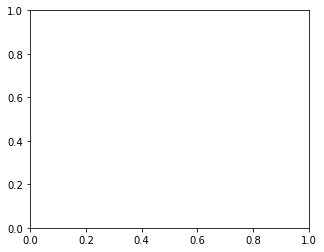

In [56]:
learning_rates = [3*1e-3]
decays = [0.95]
batch_sizes = [32]             # obligé de le mettre à 16 si pls L car sinon le nombre total de samples n'est pas divisible par batch_size 
nb_epochs = [25]               # et on ne peut donc pas reshape. Sinon il ne pas prendre certains samples pour que ça tombe juste.
train_losses=[]
test_losses=[]
models=[]

train(device, learning_rates, decays, batch_sizes, nb_epochs, models, train_losses, test_losses, ins[0], outs[0], ins[1], outs[1], n_in_features, nz)
train_losses_arr = np.array(train_losses)
test_losses_arr = np.array(test_losses)
print("train losses array shape : ", train_losses_arr.shape)
print("test losses array shape : ", test_losses_arr.shape)

#for i in range(len(models)):
    #torch.save(models[i].state_dict(), f"explo/models/pca_{i}.pt")

fig,axes = plt.subplots(len(decays),len(batch_sizes)*len(learning_rates),figsize=(5*len(decays),4*len(batch_sizes)*len(learning_rates)))

for i in range(len(learning_rates)):
    for j in range(len(decays)):
        for k in range(len(batch_sizes)):
            try : 
                axes[j,k+i*len(batch_sizes)].plot(train_losses_arr[i,j,k,1:], label='train')
                axes[j,k+i*len(batch_sizes)].plot(test_losses_arr[i,j,k,1:], label='test')
                axes[j,k+i*len(batch_sizes)].set_title(f"d = {decays[j]}, lr = {learning_rates[i]}, bs = {batch_sizes[k]}")
                axes[j,k+i*len(batch_sizes)].legend()
            except :
                pass
plt.show()